# Stability oracle

dai loro csv su github

In [1]:
import pandas
import numpy
from copy import deepcopy

import math
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
rose=pandas.read_csv('../Rose/rose1985.csv', index_col='Parameter')
rose

,Rose1985
Parameter,
A,86.6
C,132.3
D,97.8
E,113.9
F,194.1
G,62.9
H,155.8
I,158.0
K,115.5


## Fit on tz2837

### data wrestling

In [3]:
def unpack_mut(x):
    x['from_aa']= x['mutation'][0]
    x['to_aa']= x['mutation'][-1]
    return x

In [4]:
def rose_delta(x):
    x['rose_delta']=rose['Rose1985'][x['from_aa']] - rose['Rose1985'][x['to_aa']]
    return x

In [5]:
rose=pandas.read_csv('../Rose/rose1985.csv', index_col='Parameter')
rose

,Rose1985
Parameter,
A,86.6
C,132.3
D,97.8
E,113.9
F,194.1
G,62.9
H,155.8
I,158.0
K,115.5


In [6]:
so_raw=pandas.read_csv('T2837.csv').apply(unpack_mut,axis=1)
so_raw['experimental']=True
so_raw

,pdb_id,mutation,chain_id,ddg,ddg_pred,from_aa,to_aa,experimental
0,2zta,R25A,A,1.66,0.034603,R,A,True
1,1mgr,Y54F,A,2.60,0.165338,Y,F,True
2,1div,E38Q,A,0.68,-0.055389,E,Q,True
3,2chf,I55V,A,1.50,0.122901,I,V,True
4,1ey0,P117T,A,-1.10,-0.076891,P,T,True
...,...,...,...,...,...,...,...,...
2825,3dv0,L159A,I,2.00,0.558340,L,A,True
2826,3dv0,L159G,I,1.90,1.115305,L,G,True
2827,1lz1,D67H,A,4.54,0.372426,D,H,True
2828,1w4e,V158A,A,3.20,0.733503,V,A,True


In [7]:
def anti(x):
    #_anti = deepcopy(x)
    x['to_aa'], x['from_aa']  =  x['from_aa'], x['to_aa']
    #x['ll_mut'], x['ll_native']  =  x['ll_native'], x['ll_mut']
    x['ddg'] = -x['ddg']
    x['ddg_pred'] = -x['ddg_pred']
    x['experimental'] = False
    return x

In [8]:
so_double = pandas.concat([so_raw, so_raw.apply(anti, axis=1)],ignore_index=True)
so_double

,pdb_id,mutation,chain_id,ddg,ddg_pred,from_aa,to_aa,experimental
0,2zta,R25A,A,1.66,0.034603,R,A,True
1,1mgr,Y54F,A,2.60,0.165338,Y,F,True
2,1div,E38Q,A,0.68,-0.055389,E,Q,True
3,2chf,I55V,A,1.50,0.122901,I,V,True
4,1ey0,P117T,A,-1.10,-0.076891,P,T,True
...,...,...,...,...,...,...,...,...
5655,3dv0,L159A,I,-2.00,-0.558340,A,L,False
5656,3dv0,L159G,I,-1.90,-1.115305,G,L,False
5657,1lz1,D67H,A,-4.54,-0.372426,H,D,False
5658,1w4e,V158A,A,-3.20,-0.733503,A,V,False


In [9]:
def encode_mutation(x):
    x[x['from_aa']]= -1
    x[x['to_aa']] = 1
    return x

In [10]:
ddfep_opt = deepcopy(so_double)
for _ in sorted(rose.index):
    ddfep_opt[_] = 0
ddfep_opt = ddfep_opt.apply(encode_mutation, axis=1).apply(rose_delta, axis=1)

In [11]:
ddfep_opt

,pdb_id,mutation,chain_id,ddg,ddg_pred,from_aa,to_aa,experimental,A,C,...,N,P,Q,R,S,T,V,W,Y,rose_delta
0,2zta,R25A,A,1.66,0.034603,R,A,True,1,0,...,0,0,0,-1,0,0,0,0,0,75.6
1,1mgr,Y54F,A,2.60,0.165338,Y,F,True,0,0,...,0,0,0,0,0,0,0,0,-1,-16.4
2,1div,E38Q,A,0.68,-0.055389,E,Q,True,0,0,...,0,0,1,0,0,0,0,0,0,-5.3
3,2chf,I55V,A,1.50,0.122901,I,V,True,0,0,...,0,0,0,0,0,0,1,0,0,17.0
4,1ey0,P117T,A,-1.10,-0.076891,P,T,True,0,0,...,0,-1,0,0,0,1,0,0,0,-13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655,3dv0,L159A,I,-2.00,-0.558340,A,L,False,-1,0,...,0,0,0,0,0,0,0,0,0,-77.5
5656,3dv0,L159G,I,-1.90,-1.115305,G,L,False,0,0,...,0,0,0,0,0,0,0,0,0,-101.2
5657,1lz1,D67H,A,-4.54,-0.372426,H,D,False,0,0,...,0,0,0,0,0,0,0,0,0,58.0
5658,1w4e,V158A,A,-3.20,-0.733503,A,V,False,-1,0,...,0,0,0,0,0,0,1,0,0,-54.4


### fit USC(MBC) and USC(Rose)

In [12]:
X_rose = ddfep_opt[["ddg_pred", "rose_delta"]].to_numpy()
X_mbc = ddfep_opt[["ddg_pred"] + sorted(list(rose.index))].to_numpy()
y = ddfep_opt["ddg"]

In [13]:
ddmbc_model = LinearRegression(fit_intercept=False).fit(
    X_mbc,
    y,
)

In [14]:
ddmbc_model.coef_, ddmbc_model.intercept_, math.sqrt(ddmbc_model.score(X_mbc, y))

(array([ 2.45500646,  0.05882245, -0.05174425, -0.34025591, -0.23154003,
         0.55353596, -0.01230222, -0.037943  ,  0.48611766, -0.12936253,
         0.24301729,  0.01074142, -0.3692464 , -0.0645848 , -0.00595296,
        -0.32097771, -0.31188875, -0.21996018,  0.4034574 ,  0.07993   ,
         0.26013657]),
 0.0,
 0.7470836238759102)

#### ddMBC coefs

In [15]:
coefs=dict(zip(["delta"] + sorted(list(rose.index)), ddmbc_model.coef_))
#coefs
coefs_df = pandas.DataFrame({'StabilityOracle': coefs})
coefs_df
#coefs_df.to_csv('so_params.csv')

,StabilityOracle
delta,2.455006
A,0.058822
C,-0.051744
D,-0.340256
E,-0.231540
F,0.553536
G,-0.012302
H,-0.037943
I,0.486118
K,-0.129363


### UFSC(Rose)

In [16]:
rose_model = LinearRegression(fit_intercept=False).fit(
    X_rose,
    y,
)

In [17]:
rose_model.coef_, rose_model.intercept_, math.sqrt(rose_model.score(X_rose, y))

(array([ 2.34521458e+00, -2.15781002e-03]), 0.0, 0.7358074440386999)

## S669

In [18]:
so_dir=pandas.read_csv('S669.csv')
so_dir['experimental']=True
so_inv=pandas.read_csv('S669_r.csv')
so_inv['experimental']=False
#so_dir
so_s669=pandas.concat([so_dir,so_inv],ignore_index=True)
so_s669['hash']= so_s669.apply(lambda x: '_'.join([x['pdb_id'].upper()+x['chain_id'], x['mutation'] ]), axis=1)
so_s669

,pdb_id,mutation,chain_id,ddg,ddg_pred,experimental,hash
0,1div,K10M,A,-0.050,-0.127811,True,1DIVA_K10M
1,1div,L6A,A,3.100,0.662403,True,1DIVA_L6A
2,1div,E17Q,A,0.210,0.039147,True,1DIVA_E17Q
3,1gua,C96A,B,1.759,0.634264,True,1GUAB_C96A
4,1gua,Q66A,B,0.504,-0.012379,True,1GUAB_Q66A
...,...,...,...,...,...,...,...
1327,1div,A141L,A,-3.560,-1.987181,False,1DIVA_A141L
1328,1div,A30L,A,-2.760,-1.600889,False,1DIVA_A30L
1329,1div,L21V,A,-1.230,-0.451907,False,1DIVA_L21V
1330,1div,A98I,A,-4.280,-1.977207,False,1DIVA_A98I


In [19]:
dir_filter=so_s669['experimental'] == True
inv_filter=so_s669['experimental'] == False

In [20]:
#s0_s669_plot = so_[exp_filter].plot.scatter(x='ddfep_opt',y='ddg', grid=True)
so_dir[['ddg','ddg_pred']].corr()

,ddg,ddg_pred
ddg,1.000000,0.498682
ddg_pred,0.498682,1.000000


In [21]:
#s0_s669_plot = so_[exp_filter].plot.scatter(x='ddfep_opt',y='ddg', grid=True)
so_inv[['ddg','ddg_pred']].corr()

,ddg,ddg_pred
ddg,1.000000,0.495286
ddg_pred,0.495286,1.000000


In [22]:
so_s669= so_s669.apply(unpack_mut, axis=1).apply(rose_delta, axis=1)
so_s669.head()

,pdb_id,mutation,chain_id,ddg,ddg_pred,experimental,hash,from_aa,to_aa,rose_delta
0,1div,K10M,A,-0.050,-0.127811,True,1DIVA_K10M,K,M,-57.4
1,1div,L6A,A,3.100,0.662403,True,1DIVA_L6A,L,A,77.5
2,1div,E17Q,A,0.210,0.039147,True,1DIVA_E17Q,E,Q,-5.3
3,1gua,C96A,B,1.759,0.634264,True,1GUAB_C96A,C,A,45.7
4,1gua,Q66A,B,0.504,-0.012379,True,1GUAB_Q66A,Q,A,32.6


In [23]:
#ddfep_opt = deepcopy(so_double)
for _ in sorted(rose.index):
    so_s669[_] = 0
so_s669 = so_s669.apply(encode_mutation, axis=1).apply(rose_delta, axis=1)

In [24]:
so_s669

,pdb_id,mutation,chain_id,ddg,ddg_pred,experimental,hash,from_aa,to_aa,rose_delta,...,M,N,P,Q,R,S,T,V,W,Y
0,1div,K10M,A,-0.050,-0.127811,True,1DIVA_K10M,K,M,-57.4,...,1,0,0,0,0,0,0,0,0,0
1,1div,L6A,A,3.100,0.662403,True,1DIVA_L6A,L,A,77.5,...,0,0,0,0,0,0,0,0,0,0
2,1div,E17Q,A,0.210,0.039147,True,1DIVA_E17Q,E,Q,-5.3,...,0,0,0,1,0,0,0,0,0,0
3,1gua,C96A,B,1.759,0.634264,True,1GUAB_C96A,C,A,45.7,...,0,0,0,0,0,0,0,0,0,0
4,1gua,Q66A,B,0.504,-0.012379,True,1GUAB_Q66A,Q,A,32.6,...,0,0,0,-1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1div,A141L,A,-3.560,-1.987181,False,1DIVA_A141L,A,L,-77.5,...,0,0,0,0,0,0,0,0,0,0
1328,1div,A30L,A,-2.760,-1.600889,False,1DIVA_A30L,A,L,-77.5,...,0,0,0,0,0,0,0,0,0,0
1329,1div,L21V,A,-1.230,-0.451907,False,1DIVA_L21V,L,V,23.1,...,0,0,0,0,0,0,0,1,0,0
1330,1div,A98I,A,-4.280,-1.977207,False,1DIVA_A98I,A,I,-71.4,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#for _l, _m in [('ddg_mbc',ddmbc_model),('ddg_mbc_rose',rose_model)]:
X_s669_rose = so_s669[["ddg_pred", "rose_delta"]].to_numpy()
X_s669_mbc = so_s669[["ddg_pred"] + sorted(list(rose.index))].to_numpy()

so_s669['ddg_mbc']=ddmbc_model.predict(X_s669_mbc)
so_s669['ddg_mbc_rose']=rose_model.predict(X_s669_rose)      
so_s669.head()

,pdb_id,mutation,chain_id,ddg,ddg_pred,experimental,hash,from_aa,to_aa,rose_delta,...,P,Q,R,S,T,V,W,Y,ddg_mbc,ddg_mbc_rose
0,1div,K10M,A,-0.050,-0.127811,True,1DIVA_K10M,K,M,-57.4,...,0,0,0,0,0,0,0,0,-0.173672,-0.175886
1,1div,L6A,A,3.100,0.662403,True,1DIVA_L6A,L,A,77.5,...,0,0,0,0,0,0,0,0,1.442009,1.386247
2,1div,E17Q,A,0.210,0.039147,True,1DIVA_E17Q,E,Q,-5.3,...,0,1,0,0,0,0,0,0,0.321693,0.103245
3,1gua,C96A,B,1.759,0.634264,True,1GUAB_C96A,C,A,45.7,...,0,0,0,0,0,0,0,0,1.667690,1.388874
4,1gua,Q66A,B,0.504,-0.012379,True,1GUAB_Q66A,Q,A,32.6,...,0,-1,0,0,0,0,0,0,0.034384,-0.099377


In [26]:
#s0_s669_plot = so_[exp_filter].plot.scatter(x='ddfep_opt',y='ddg', grid=True)
pred_labelz= ['ddg_pred','ddg_mbc','ddg_mbc_rose' ]
so_s669[ pred_labelz].corrwith(so_s669['ddg'])

ddg_pred        0.650248
ddg_mbc         0.658294
ddg_mbc_rose    0.647370
dtype: float64

In [27]:
for _ in pred_labelz:
    print( _, 'S669 direct RMSE:',math.sqrt(mean_squared_error(so_s669['ddg'],so_s669[_])) )
#print( 'S669 all RMSE:',math.sqrt(mean_squared_error(so_s669['ddg'],so_s669['ddg_pred'])) )

ddg_pred S669 direct RMSE: 1.522129619391386
ddg_mbc S669 direct RMSE: 1.5617837639121772
ddg_mbc_rose S669 direct RMSE: 1.5654164987943706


## S461

alla vecchia

In [28]:
def revmut(x):
    "generate reverse-mutation code"
    return ''.join([x[-1],x[1:-1],x[0]])

In [29]:
s461_df=pandas.read_csv('s461_muts.csv',sep=' ')
s461_df['revmut']=s461_df['mut'].apply(revmut)
s461_df.head()

,pdb,mut,ddg,revmut
0,1A0FA,S11A,-1.800,A11S
1,1BA3A,H461D,-1.745,D461H
2,1BA3A,H489D,0.287,D489H
3,1BA3A,H489K,-0.287,K489H
4,1BA3A,H489M,-0.263,M489H


In [30]:
s461_hashes=set(s461_df.apply(lambda x: '_'.join([x['pdb'],x['mut']]),axis=1))
s461_hashes.update(set(s461_df.apply(lambda x: '_'.join([x['pdb'],x['revmut']]),axis=1) ))
#s461_hashes

In [31]:
so_s669['s461']=so_s669['hash'].apply(lambda x: x in s461_hashes)
so_s669.head()
#sum(so_s669['s461'])

,pdb_id,mutation,chain_id,ddg,ddg_pred,experimental,hash,from_aa,to_aa,rose_delta,...,Q,R,S,T,V,W,Y,ddg_mbc,ddg_mbc_rose,s461
0,1div,K10M,A,-0.050,-0.127811,True,1DIVA_K10M,K,M,-57.4,...,0,0,0,0,0,0,0,-0.173672,-0.175886,True
1,1div,L6A,A,3.100,0.662403,True,1DIVA_L6A,L,A,77.5,...,0,0,0,0,0,0,0,1.442009,1.386247,True
2,1div,E17Q,A,0.210,0.039147,True,1DIVA_E17Q,E,Q,-5.3,...,1,0,0,0,0,0,0,0.321693,0.103245,True
3,1gua,C96A,B,1.759,0.634264,True,1GUAB_C96A,C,A,45.7,...,0,0,0,0,0,0,0,1.667690,1.388874,True
4,1gua,Q66A,B,0.504,-0.012379,True,1GUAB_Q66A,Q,A,32.6,...,-1,0,0,0,0,0,0,0.034384,-0.099377,True


ddg_pred s461 RMSE: 1.1789942220675833
ddg_mbc s461 RMSE: 1.191423726613177
ddg_mbc_rose s461 RMSE: 1.1686320632124607


ddg_pred        0.799331
ddg_mbc         0.798575
ddg_mbc_rose    0.795272
dtype: float64

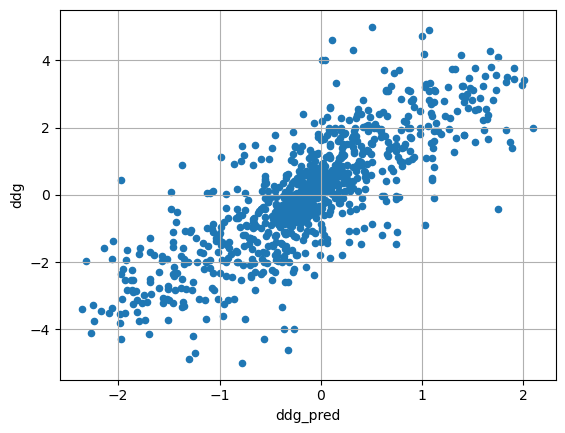

In [36]:
so_s461= so_s669[so_s669['s461']]
so_s461_plot = so_s461.plot.scatter(x='ddg_pred',y='ddg', grid=True)
for _ in pred_labelz:
    print(_,'s461 RMSE:',math.sqrt(mean_squared_error(so_s461['ddg'],so_s461[_])))
so_s461[pred_labelz].corrwith(so_s461['ddg'])

In [33]:
so_s461[so_s461['experimental']][['ddg']+pred_labelz].corr()

,ddg,ddg_pred,ddg_mbc,ddg_mbc_rose
ddg,1.000000,0.641868,0.623535,0.635598
ddg_pred,0.641868,1.000000,0.982532,0.998035
ddg_mbc,0.623535,0.982532,1.000000,0.985231
ddg_mbc_rose,0.635598,0.998035,0.985231,1.000000
